# Fine-tuning SAM on Satellite Images for Street Segmentation

Our approach is based on reusing the pretrained SAM Vision Transformer, more specifically using the image encoder and discarding the prompt encoder and mask decoder. 

Instead we will try out a combination of different Custom Encoder thats we use on the encoded images. 

We will try to use different approaches for the Decocer: 

1. Conv/Deconv based approach
2. Fully connected MLP's
3. Same as the mask decoder? 
4. Transformer, ViT? 

Another idea is to use adapter finetuning ?

Furthermore things that can be modified are how many last layers of the SAM encoder are also fine tuned? 
Possibly just finetune them, after a while of training the newly initialized decoder. 

We will work with a lr schedule that reduces on plateau.


---
### Loss function: 
We use combination of the following: 
- DiceLoss
- FocalLoss
- BCEWithLogitsLoss
---
### Learning rate:
- really small values
- reduceLROnPlateau(optimizer, 'max', patience=reduce_patience, verbose=verbose, factor=reduce_factor)
- cosine annealing


TODO: 

- IMPLEMENT LR SCHEDULE AND STOPPING CRITERIA
- CHECK OUT OTHER DECODERS SegFormer, MLP ... 
- CHECK OUT TO TRAIN MORE LAYERS OF TRANSFORMER

# Novel Ideas:

- LOOK AT VIT ARCHITECTURE
- TRAIN FROM SCRATCH, VARIE SOMETHING WITH LOCAL/GLOBAL ATTENTION or try some COMBINATION RESIDUAL/SKIP CONNECTIONS.



In [1]:
import torch
import numpy as np
import random

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


## Loading the dataset

In [2]:
# written by Jannek Ulm 16.5.2024
# code was inspired by the following sources: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

from utils.image_loading import * 
from utils.torch_device import *
from custom_datasets import Sat_Mask_Dataset, Sat_Only_Image_Dataset

device = get_torch_device(allow_mps=True)
print("using device:",device)

###########

original_data = {}

original_data["images"] =load_training_images()
original_data["masks"] = load_groundtruth_images()
original_data["images"].extend(load_groundtruth_images("EPFL"))
original_data["masks"].extend(load_groundtruth_images("EPFL"))

city_names = ["boston","nyc","philadelphia","austin"]
custom_data = {"images":[],"masks":[]} # stores images and gt masks

for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

custom_data["images"] = custom_data["images"]
custom_data["masks"] = custom_data["masks"]

assert (len(custom_data["images"]) == len(custom_data["masks"]))


print("the raw custom dataset contains",len(custom_data["images"]),"images")

print("custom ds: (min,mean,max) street ratio",get_street_ratio_mmm(custom_data["masks"]))
print("orig ds: (min,mean,max) street ratio",get_street_ratio_mmm(original_data["masks"]))
print("custom ds with ignore under threshold: (min,mean,max) street ratio",get_street_ratio_mmm(custom_data["masks"],min_ratio_threshold=0.03))
# create a dataset
custom_data_set = Sat_Mask_Dataset(custom_data["images"], custom_data["masks"],min_street_ratio=0.03,max_street_ratio=1.0)
original_data_set = Sat_Mask_Dataset(original_data["images"],original_data["masks"])
print("after cleanup, the dataset now contains",len(custom_data_set),"images")


# submission kaggle dataset

kaggle_submission_images = load_test_images()
submission_data_set = Sat_Only_Image_Dataset(kaggle_submission_images)


using device: cuda:0
the raw custom dataset contains 12985 images
custom ds: (min,mean,max) street ratio (0.0, 0.13372669666923362, 0.72180625)
orig ds: (min,mean,max) street ratio (0.00530625, 0.18724623463114762, 0.43706249999999996)
custom ds with ignore under threshold: (min,mean,max) street ratio (0.03005625, 0.14823332153582142, 0.72180625)
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.10242587601078167  num discarded: 1330
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
after cleanup, the dataset now contains 11655 images


In [3]:
# print num of data in original and custom dataset
print("original dataset contains",len(original_data_set),"images")
print("custom dataset contains",len(custom_data_set),"images")

original dataset contains 244 images
custom dataset contains 11655 images


In [4]:
dataset = custom_data_set
print(dataset[0][0].shape, dataset[0][0].dtype, dataset[0][0].mean(), dataset[0][0].min(), dataset[0][0].max())
print(dataset[0][1].shape, dataset[0][1].dtype, dataset[0][1].mean(), dataset[0][1].min(), dataset[0][1].max())

torch.Size([3, 1024, 1024]) torch.float32 tensor(133.7138) tensor(1.) tensor(254.)
torch.Size([1, 1024, 1024]) torch.float32 tensor(0.3802) tensor(0.) tensor(1.)


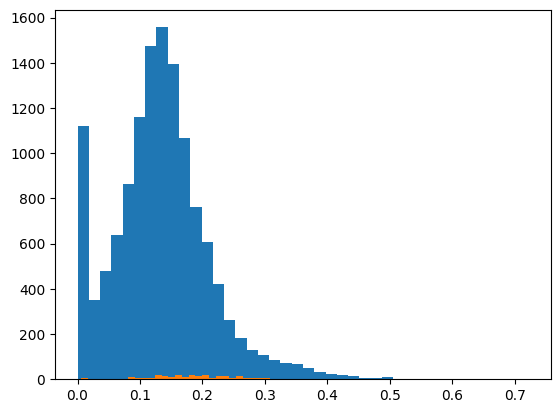

In [5]:
# plot the street ratio distribution of the dataset

custom_ratios = get_street_ratio_distr(custom_data["masks"])
original_ratios = get_street_ratio_distr(original_data["masks"])

plt.hist(custom_ratios,40)
plt.hist(original_ratios,40)
plt.show()

img:  (1024, 1024, 3) uint8 1 254 133.7029275894165
mask2:  (1024, 1024, 1) uint8 0 255
cmb:  (1024, 1024, 3) uint8 0 255 119.07334073384602


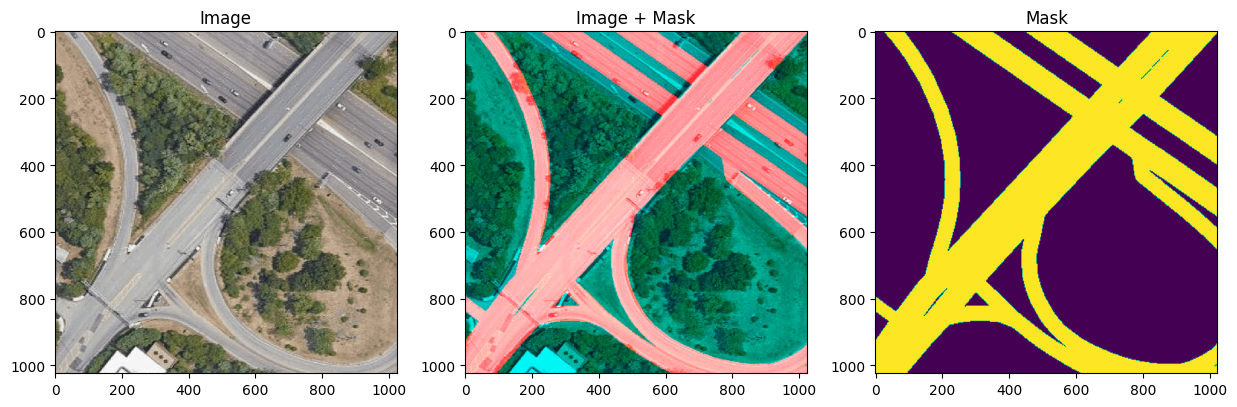

0 255 0.0 1.0


In [6]:
# make sure the dataset loading works as planned: 

import matplotlib.pyplot as plt

# get some random training images
idx = 0
image, mask = custom_data_set[idx]

img = np.array(image).astype(np.uint8)
# swap first and third dimension
img = np.swapaxes(img, 0, 2)
mask = np.array(mask)
mask = np.swapaxes(mask, 0, 2)

# 1x2 plot: 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img)

# image + mask overlay
plt.subplot(1, 3, 2)
plt.title("Image + Mask")
print("img: ",img.shape,img.dtype,img.min(),img.max(),img.mean())
mask2 = (mask * 255.).astype(np.uint8)
print("mask2: ",mask2.shape,mask2.dtype,mask2.min(),mask2.max())
cmb = img
cmb[:,:,0] = mask2[:,:,0]  
print("cmb: ",cmb.shape,cmb.dtype,cmb.min(),cmb.max(),cmb.mean())
plt.imshow(cmb)

# mask
plt.subplot(1, 3, 3)
plt.title("Mask")
plt.imshow(mask)
plt.show()
print(img.min(), img.max(), mask.min(), mask.max())


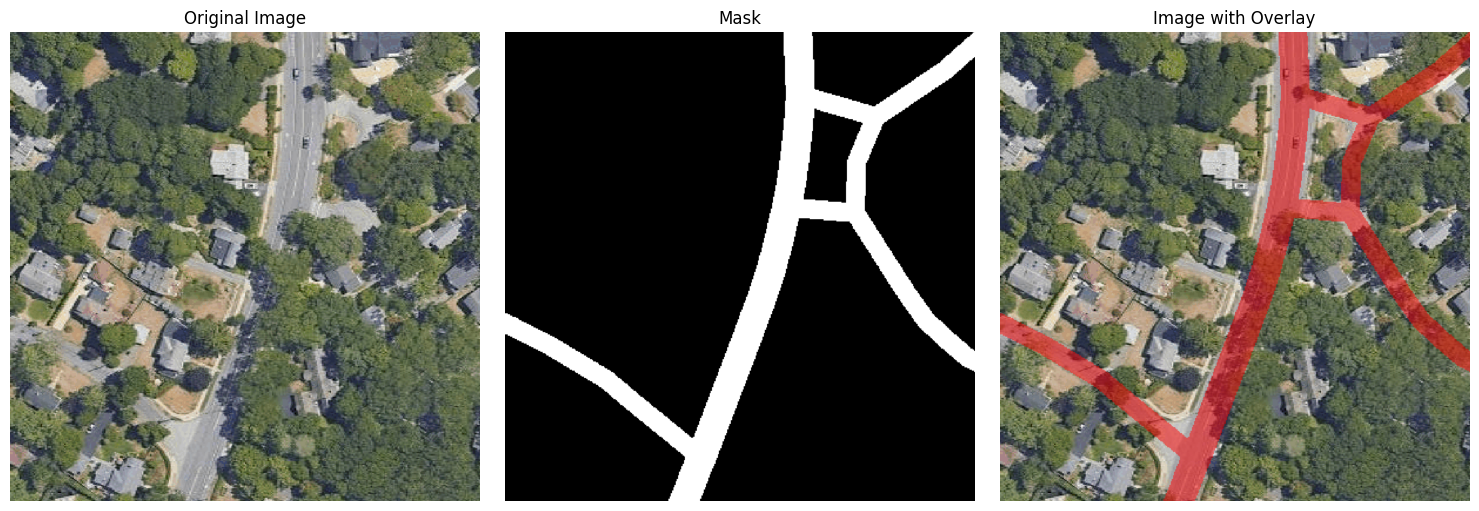

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# get some random training images
idx = 4
image, mask = custom_data_set[idx]

img = np.array(image).astype(np.uint8)
# swap first and third dimension
img = np.swapaxes(img, 0, 2)
mask = np.array(mask)
mask = np.swapaxes(mask, 0, 2)

# Create a reddish tone image with the same shape as the original image
reddish_tone = np.zeros_like(img)
reddish_tone[..., 0] = 255  # Red channel to maximum

# Define the opacity for the overlay
opacity = 0.5

# Ensure the mask is binary (0 or 255) and has the same shape as the original image
binary_mask = (mask > 0).astype(np.uint8) * 255

# Blend the original image and the reddish tone based on the mask
blended_image = np.where(binary_mask == 255, 
                         (img * (1 - opacity) + reddish_tone * opacity).astype(np.uint8),
                         img)

# Display the original image, mask, and blended image side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')

axes[2].imshow(blended_image)
axes[2].set_title('Image with Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Dataloader

In [8]:
train_split = 0.8


gpu_batch_size = 1

import torch.utils.data
custom_train_dataset, custom_test_dataset = torch.utils.data.random_split(custom_data_set, [train_split, 1-train_split])
original_train_dataset, original_test_dataset = torch.utils.data.random_split(original_data_set, [train_split, 1-train_split])


print(len(custom_train_dataset), len(custom_test_dataset))

from torch.utils.data import DataLoader


# CHECK IF THE FOR MULTIPLE NUM WORKERS THE CODE WORKS AS EXPECTED
# SEEMS TO BE CAUSING ISSUES WITH LONG startup and shutdown times for each epoch

# decided to drop last to make f1/loss score mean computation easier.

original_train_dataloader = DataLoader(original_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
original_test_dataloader = DataLoader(original_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)
original_dataloader = DataLoader(original_data_set, batch_size=1, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)

# dataloader for submission dataset: 
submission_dataloader = DataLoader(submission_data_set, batch_size=1, shuffle=False, drop_last=False,num_workers=4,persistent_workers=True)

#custom_train_dataloader = DataLoader(custom_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
#custom_test_dataloader = DataLoader(custom_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)
custom_dataloader = DataLoader(custom_data_set, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)

9325 2330


## Loading the model

In [9]:

############ (CUSTOM SAM (stored in repo))
from custom_segment_anything.segment_anything import sam_model_registry
from custom_segment_anything.segment_anything.CUSTOM_SAM import *

# load the model from checkpoints on disk:
def load_sam_decoder_model_from_checkpoint(encoder_option:int, device,decoder):
    #
    # encoder_option =0 : for vit_b with the encoder that just retunrs the final block output.
    # encoder_option =1 : for vit_b with the encoder that returns the intermediate outputs + final output.  

    sam_checkpoint_path = "custom_segment_anything/model_checkpoints/"
    # base, large, huge checkpoints. 
    checkpoint_names = ["vit_b","vit_b_intermediate"]#,"vit_l","vit_h"]
    checkpoints = ["sam_vit_b_01ec64.pth"] #,"sam_vit_l_0b3195.pth","sam_vit_h_4b8939.pth"]
    model_paths = [sam_checkpoint_path+checkpoint_name for checkpoint_name in checkpoints]
    sam = sam_model_registry[checkpoint_names[encoder_option]](checkpoint=model_paths[0])
    sam.to(device)
    model = SAM_Encoder_Custom_Decoder(sam.preprocess, sam.image_encoder,decoder=decoder)
    model = model.to(device)
    return model


# load the finetnued model state, if already started training. 
def load_finetuned_model(name,device,decoder):
    model = load_sam_decoder_model_from_checkpoint(0,device,decoder)
    finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
    model.load_state_dict(torch.load(finetune_path+name,map_location=torch.device('cpu')))
    model = model.to(device)
    return model

############################



def load_sam_model(decoder_option, device, encoder_finetune_num_first_layers,encoder_finetune_num_last_layers,finetuned_model_name="model.pth",sam_checkpoint_or_finetuned="sam"):
    #   
    #   decoder_options: ["conv", "mlp" , "spatial-full", "spatial-small", "skip-connect]
    #   encoder_finetune_num_last_layers tells how many layers of sam encoder are finetuned, all decoder layers are tuned. 
    #   sam_checkpoint_or_finetuned checks if the model is loaded from a sam checkpoint or a finetuned model with the same architecture.
    #

    # first construct the model from sam_checkpoint:

    if decoder_option == "conv":
        decoder = Conv_Decoder()
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder.decoder)
   
    elif decoder_option == "mlp":
        decoder = MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder)

    elif decoder_option == "spatial-full":
        decoder = MLP_Decoder_Spatially_Aware(context_option=1)
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder)

    elif decoder_option == "spatial-small":
        decoder = MLP_Decoder_Spatially_Aware(context_option=0)
        model = load_sam_decoder_model_from_checkpoint(0,device,decoder)
    elif decoder_option == "skip-connect":
        decoder = Skip_MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(1,device,decoder)
    else:
        raise ValueError("invalid decoder option")
    
    # if should load from fine-tuned model, load the model from the finetuned path.
    if sam_checkpoint_or_finetuned == "finetuned":
        finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
        model.load_state_dict(torch.load(finetune_path+finetuned_model_name+".pth",map_location=torch.device('cpu')))
    elif sam_checkpoint_or_finetuned == "sam":
        pass
        # already initialized model from sam_checkpoint
    else: 
        raise ValueError("invalid sam_checkpoint_or_finetuned option")
    
    
    # Unfreeze last layers of the encoder
    for layer_number, param in enumerate(model.sam_encoder.parameters()):
        if layer_number > 176 - encoder_finetune_num_last_layers or layer_number < encoder_finetune_num_first_layers:
            param.requires_grad = True
        else:
            param.requires_grad = False
    
    # Unfreeze neck of the encoder
    model.sam_encoder.neck.requires_grad = True
    #model.requires_grad = True
    print("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))
    model = model.to(device)
    return model

# Actually loading the model

In [10]:
"""
finetuned_model_name = "model_best_so_far.pth"

model = load_sam_model("skip-connect",device,encoder_finetune_num_last_layers=0,finetuned_model_name=finetuned_model_name,sam_checkpoint_or_finetuned="finetuned")

print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))
"""

'\nfinetuned_model_name = "model_best_so_far.pth"\n\nmodel = load_sam_model("skip-connect",device,encoder_finetune_num_last_layers=0,finetuned_model_name=finetuned_model_name,sam_checkpoint_or_finetuned="finetuned")\n\nprint("Model loaded")\n# how many trainable parameters does the model have?\nprint("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))\n# how many total parameters does the model have?\nprint("Total parameters",sum(p.numel() for p in model.parameters()))\n\n# percentage of trainable parameters\nprint("Percentage of trainable parameters: ")\nprint("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))\n'

In [11]:
#print(model)

In [12]:
#for name, param in model.named_parameters():
#    print(name, param.requires_grad)

# Loss Functions

In [13]:

from torcheval.metrics.functional import multiclass_f1_score
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss

def mean_f1_score_from_logits(pred,mask):
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # compute the mean for all the images
    # computes the mean over the 0-th axis
    pred_classes = torch.round(torch.sigmoid(pred))
    return mean_f1_score_from_classes(mask,pred_classes)


def mean_f1_score_from_classes(preds,masks):
    
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # this computes the f1 over the whole batch, for each image in the batch alone:
    
    # first reshape the tensors
    b_size = masks.shape[0]
    f1_acc = 0.
    size = torch.prod(torch.tensor(masks.shape[1:]))
    for i in range(b_size):
        mask = masks[i]
        pred = preds[i]
        # reshape and compute f1
        f1_acc = f1_acc + multiclass_f1_score(pred.reshape((size)),mask.reshape((size)))
        
    mean_f1 = f1_acc/b_size
    return mean_f1


def wrong_dice_loss(logits,masks, smooth=1e-6):
    
    probs = torch.sigmoid(logits)
    probs_flat = probs.reshape(-1)
    masks_flat = probs.reshape(-1)
    
    intersection = (probs_flat * masks_flat).sum()
    union = probs_flat.sum() + masks_flat.sum()
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff


def dice_loss(logits,masks, smooth=1e-6):
    
    probs = torch.sigmoid(logits)
    probs_flat = probs.reshape(-1)
    masks_flat = masks.reshape(-1)
    
    intersection = (probs_flat * masks_flat).sum()
    union = probs_flat.sum() + masks_flat.sum()
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff


class_weights = torch.tensor([1./0.13]).to(device)  # Example weights: adjust based on your dataset
bce_loss = nn.BCEWithLogitsLoss(weight=class_weights)

def focal_loss(logits, masks, alpha=0.15, gamma=2.0):
    probs = torch.sigmoid(logits)
    loss = sigmoid_focal_loss(probs, masks, alpha=alpha, gamma=gamma, reduction='mean')
    return loss


def only_bce(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = masks.reshape((batch_size,1024*1024))
    
    return bce_loss(logits_sq, mask_sq)

def combined_loss_p2_norm(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = masks.reshape((batch_size,1024*1024))
    return bce_loss(logits_sq, mask_sq) + wrong_dice_loss(logits, masks, smooth=smooth)

def combined_loss_dice(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = masks.reshape((batch_size,1024*1024))
    
    return dice_loss(logits, masks, smooth=smooth) + bce_loss(logits_sq, mask_sq)

# Training Loop - Experiment best loss function

# now add the logic 

go over all possible decoder models

train for a few epochs with only few encoder layers unlocked until the last epoch didnt improve the original loss
increase the number of layers finetuned, 
if the whole epoch didnt improve, then stop the training in general

always store the model, start each new layer round with the best of the last or second last stored model. 


In [14]:
### CLEAR ALL CUDA MEMORY

import gc
torch.cuda.empty_cache()
gc.collect()

import torch
from tqdm import tqdm
import torch.nn as nn


train_loader = custom_dataloader
test_loader = original_dataloader


########
# print interval and num_steps for gradient accumulation
print_interval = len(train_loader) // 10
do_intermed_prints = False



#########

decoder_options =  ["conv","spatial-small","spatial-full","skip-connect"]  #["mlp"]
num_layers_to_finetune_back = [25,65,85,105]
num_layers_to_finetune_front = [0,0,15,25]
learning_rates = [0.001,0.0001, 0.0001,0.0001]
loss_functions = [only_bce,combined_loss_p2_norm,combined_loss_dice]
max_epochs = [3,3,4,4]
grad_batch_size_choices = [5,5,5,5]

##################################
# TRAINING LOOP
################################

#for loss_fn_idx in range(len(loss_functions)):


#for loss_fn_idx in range(len(loss_functions)):
loss_fn_idx = 2
for decoder_option in decoder_options:
    for idx_layer_option in range(2,len(num_layers_to_finetune_back)):
        # set the max number of epochs for this layer option
        max_num_epochs = max_epochs[idx_layer_option]
        min_num_epochs = 0
        if idx_layer_option ==2:
            min_num_epochs = 2
        for epoch_counter in range(min_num_epochs,max_num_epochs):
            torch.cuda.empty_cache()
            gc.collect()

            epoch_to_train = epoch_counter
            layer_option_back = num_layers_to_finetune_back[idx_layer_option]
            layer_option_front = num_layers_to_finetune_front[idx_layer_option]
            
            # if the layer_option is larger than 1 (i.e. if at least 85 layers in the back are tuned, reduce lr.), reduce lr 
            learning_rate = learning_rates[idx_layer_option]
            if idx_layer_option >= 2:
                learning_rate = learning_rate / (epoch_counter + 1)
                print("divided lr")
            print("using lr:",learning_rate)
            loss_fn = loss_functions[loss_fn_idx]
            print("using loss function:",loss_fn)
            grad_batch_size = grad_batch_size_choices[loss_fn_idx]
            
            #####################################            
            # now training this model 
            current_model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option_front}_{layer_option_back}_epoch_{epoch_counter}"
            print("training model:",current_model_description)
            # check if this current model description already exists, if so, load the model and skip this exact training step:
            if os.path.exists("custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth"):
                print("model already exists, skipping training for this layer option")
                continue
            # since model was not already trained
            # load the "start model from checkpoint or finetuned"
            # load the initial model from the sam checkpoint
            if idx_layer_option == 0 and epoch_counter == 0:
                print("loading model from sam checkpoint")
                model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=layer_option_front,encoder_finetune_num_last_layers=layer_option_back,finetuned_model_name=None,sam_checkpoint_or_finetuned="sam")
            else:
                
                if epoch_counter == 0:
                    last_max_epoch = max_epochs[idx_layer_option-1]
                    # now epoch 0, hence load max epoch from previous layer option
                    model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{num_layers_to_finetune_front[idx_layer_option-1]}_{num_layers_to_finetune_back[idx_layer_option-1]}_epoch_{last_max_epoch-1}"
                else:
                    # load the last epoch from current layer option
                    
                    model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option_front}_{layer_option_back}_epoch_{epoch_counter-1}"
                print("loading model from finetuned:",model_description)
                model = load_sam_model(decoder_option,device,encoder_finetune_num_first_layers=layer_option_front,encoder_finetune_num_last_layers=layer_option_back,finetuned_model_name=model_description,sam_checkpoint_or_finetuned="finetuned")
                
            # newly initializing the optimizer and scheduler since model was loaded new (do this for every epoch:)
            ####################################
            #for name, param in model.named_parameters():
            #    print(name, param.requires_grad)
            
            model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            print("Starting Epoch: ",epoch_counter)
            # training run: 
            model.train()
            # store running losses for the epoch and the 10% print interval
            epoch_running_loss = 0.0
            epoch_running_f1 = 0.0

            short_running_loss = 0.0
            short_running_f1 = 0.0

            step_counter = 0
            
            mini_batch_loss_accumulator = 0.0
            
            # reset the gradients: 
            optimizer.zero_grad()
            
            #########################################
            # TRAINING LOOP
            for image, mask in tqdm(train_loader):
                step_counter += 1
                #####################
                # forward pass
                image = image.to(device)
                mask = mask.to(device)    
                pred = model(image)
                # compute loss and f1 score: 
                loss = loss_fn(pred,mask)
                
                
                f1_score = mean_f1_score_from_logits(pred,mask).item()
                epoch_running_loss += loss.item()
                epoch_running_f1 += f1_score
                short_running_loss += loss.item()
                short_running_f1 += f1_score

                loss.backward()
                #mini_batch_loss_accumulator += loss

                ###############
                # backward pass
                if step_counter % grad_batch_size == 0:
                    # compute the gradients
                    #mini_batch_loss_accumulator = mini_batch_loss_accumulator/grad_batch_size
                    #mini_batch_loss_accumulator.backward()
                    # update the model weights
                    optimizer.step()
                    # reset the gradients
                    optimizer.zero_grad()
                    #mini_batch_loss_accumulator = 0.0
                
                if do_intermed_prints and step_counter % print_interval == 0:
                    print("step: ",step_counter//print_interval)
                    # print out the current losses:
                    print(f"Epoch: {epoch_counter}, step: {step_counter//print_interval}, (train) Loss: {short_running_loss/print_interval}, F1: {short_running_f1/print_interval}")
                    # and reset the short running losses
                    short_running_loss = 0.0
                    short_running_f1 = 0.0

            
                
                
            
            print(f"Epoch: {epoch_counter}, (train) Loss: {epoch_running_loss/len(train_loader)}, F1: {epoch_running_f1/len(train_loader)}")
            ########################################
            # save the model in every epoch
            print("saving model:",current_model_description)
            torch.save(model.state_dict(), "custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth")
            #########################################
            
            # testing run: 
            model.eval()
            with torch.no_grad():
                l_acc = 0.0
                score_acc = 0.0
                for image,mask in tqdm(test_loader):
                    image = image.to(device)
                    mask = mask.to(device)
                    pred = model(image)
                    # compute loss and f1 score: 
                    score = mean_f1_score_from_logits(pred,mask)    
                    loss =  loss_fn(pred,mask)
                    # update running loss and f1 score
                    score_acc += score.item()
                    l_acc  += loss.item()
                    # store the loss and f1 score
                print(f"Epoch: {epoch_counter}, (test) Loss: {l_acc/len(test_loader)}, F1-Score: {score_acc/len(test_loader)}")

        # save the model after the training run

divided lr
using lr: 3.3333333333333335e-05
using loss function: <function combined_loss_dice at 0x7f849e633c70>
training model: model_3_conv_decoder_finetune_last_15_85_epoch_2
model already exists, skipping training for this layer option
divided lr
using lr: 2.5e-05
using loss function: <function combined_loss_dice at 0x7f849e633c70>
training model: model_3_conv_decoder_finetune_last_15_85_epoch_3
loading model from finetuned: model_3_conv_decoder_finetune_last_15_85_epoch_2
Percentage of trainable parameters:  0.5590578601682892
Starting Epoch:  3


  1%|          | 118/11655 [00:34<53:00,  3.63it/s]

In [ ]:
assert False

# Now I want to finetune each model with the original data from ETH and EPFL

In [ ]:



### CLEAR ALL CUDA MEMORY

import gc
torch.cuda.empty_cache()
gc.collect()

import torch
from tqdm import tqdm
import torch.nn as nn


train_loader = original_train_dataloader
test_loader = original_test_dataloader



current_model_description = "model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_9"
model = load_sam_model("mlp",device,encoder_finetune_num_first_layers=25,encoder_finetune_num_last_layers=105,finetuned_model_name=current_model_description,sam_checkpoint_or_finetuned="finetuned")
current_model_description = "model_3_mlp_decoder_finetune_last_25_105_epoch_3"

########
# print interval and num_steps for gradient accumulation
print_interval = len(train_loader) // 10
do_intermed_prints = False



#########

decoder_options = ["mlp"] # ,"conv","spatial-small","spatial-full","skip-connect"]
num_layers_to_finetune_back = [105]
num_layers_to_finetune_front = [25]
learning_rates = [0.0001]
loss_functions = [only_bce,combined_loss_p2_norm,combined_loss_dice]
max_epochs = [0]
grad_batch_size_choices = [5]

##################################
# TRAINING LOOP
################################


loss_fn_idx = 2
for idx_layer_option in range(len(num_layers_to_finetune_back)):
    # set the max number of epochs for this layer option
    max_num_epochs = max_epochs[idx_layer_option]
    for epoch_counter in range(10,20):
        torch.cuda.empty_cache()
        gc.collect()

        epoch_to_train = epoch_counter
        layer_option_back = num_layers_to_finetune_back[idx_layer_option]
        layer_option_front = num_layers_to_finetune_front[idx_layer_option]
        
        # if the layer_option is larger than 1 (i.e. if at least 85 layers in the back are tuned, reduce lr.), reduce lr 
        learning_rate = learning_rates[idx_layer_option]
        #if idx_layer_option >= 2:
        #    learning_rate = learning_rate / (epoch_counter + 1)
        #    print("divided lr")
        print("using lr:",learning_rate)
        loss_fn = loss_functions[loss_fn_idx]
        print("using loss function:",loss_fn)
        grad_batch_size = grad_batch_size_choices[idx_layer_option]
        
        #####################################            
        # now training this model 
        
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        print("Starting Epoch: ",epoch_counter)
        # training run: 
        model.train()
        # store running losses for the epoch and the 10% print interval
        epoch_running_loss = 0.0
        epoch_running_f1 = 0.0

        short_running_loss = 0.0
        short_running_f1 = 0.0

        step_counter = 0
        
        mini_batch_loss_accumulator = 0.0
        
        # reset the gradients: 
        optimizer.zero_grad()
        
        #########################################
        # TRAINING LOOP
        for image, mask in tqdm(train_loader):
            step_counter += 1
            #####################
            # forward pass
            image = image.to(device)
            mask = mask.to(device)    
            pred = model(image)
            # compute loss and f1 score: 
            loss = loss_fn(pred,mask)
            
            
            f1_score = mean_f1_score_from_logits(pred,mask).item()
            epoch_running_loss += loss.item()
            epoch_running_f1 += f1_score
            short_running_loss += loss.item()
            short_running_f1 += f1_score

            loss.backward()
            #mini_batch_loss_accumulator += loss

            ###############
            # backward pass
            if step_counter % grad_batch_size == 0:
                # compute the gradients
                # update the model weights
                optimizer.step()
                # reset the gradients
                optimizer.zero_grad()
            
            if do_intermed_prints and step_counter % print_interval == 0:
                print("step: ",step_counter//print_interval)
                # print out the current losses:
                print(f"Epoch: {epoch_counter}, step: {step_counter//print_interval}, (train) Loss: {short_running_loss/print_interval}, F1: {short_running_f1/print_interval}")
                # and reset the short running losses
                short_running_loss = 0.0
                short_running_f1 = 0.0

        
            
            
        
        print(f"Epoch: {epoch_counter}, (train) Loss: {epoch_running_loss/len(train_loader)}, F1: {epoch_running_f1/len(train_loader)}")
        ########################################
        # save the model in every epoch
        save_model_description = current_model_description+f"_epoch_{epoch_counter}"
        print("saving model:",save_model_description)
        torch.save(model.state_dict(), "custom_segment_anything/model_checkpoints/finetuned/"+save_model_description+".pth")
        #########################################
        
        # testing run: 
        model.eval()
        with torch.no_grad():
            l_acc = 0.0
            score_acc = 0.0
            for image,mask in tqdm(test_loader):
                image = image.to(device)
                mask = mask.to(device)
                pred = model(image)
                # compute loss and f1 score: 
                score = mean_f1_score_from_logits(pred,mask)    
                loss =  loss_fn(pred,mask)
                # update running loss and f1 score
                score_acc += score.item()
                l_acc  += loss.item()
                # store the loss and f1 score
            print(f"Epoch: {epoch_counter}, (test) Loss: {l_acc/len(test_loader)}, F1-Score: {score_acc/len(test_loader)}")

    # save the model after the training run



Percentage of trainable parameters:  0.7128846751631955
using lr: 0.0001
using loss function: <function combined_loss_dice at 0x7f884df5b7f0>
Starting Epoch:  10


100%|██████████| 196/196 [00:55<00:00,  3.52it/s]


Epoch: 10, (train) Loss: 0.6069265489219403, F1: 0.9737326192612551
saving model: model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_10


100%|██████████| 48/48 [00:05<00:00,  9.13it/s]


Epoch: 10, (test) Loss: 0.7736579470414048, F1-Score: 0.9691795706748962
using lr: 0.0001
using loss function: <function combined_loss_dice at 0x7f884df5b7f0>
Starting Epoch:  11


100%|██████████| 196/196 [00:54<00:00,  3.56it/s]


Epoch: 11, (train) Loss: 0.5849011389500632, F1: 0.9747163610798972
saving model: model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_11


100%|██████████| 48/48 [00:05<00:00,  9.14it/s]


Epoch: 11, (test) Loss: 0.7945739385516694, F1-Score: 0.9692800628642241
using lr: 0.0001
using loss function: <function combined_loss_dice at 0x7f884df5b7f0>
Starting Epoch:  12


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


Epoch: 12, (train) Loss: 0.5792469405093972, F1: 0.9750328352864908
saving model: model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_12


100%|██████████| 48/48 [00:05<00:00,  9.13it/s]


Epoch: 12, (test) Loss: 0.7775408289938545, F1-Score: 0.9699758465091387
using lr: 0.0001
using loss function: <function combined_loss_dice at 0x7f884df5b7f0>
Starting Epoch:  13


100%|██████████| 196/196 [00:54<00:00,  3.60it/s]


Epoch: 13, (train) Loss: 0.5755788280951734, F1: 0.9753304546584889
saving model: model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_13


100%|██████████| 48/48 [00:05<00:00,  9.20it/s]


Epoch: 13, (test) Loss: 0.7737190027643616, F1-Score: 0.9693199967344602
using lr: 0.0001
using loss function: <function combined_loss_dice at 0x7f884df5b7f0>
Starting Epoch:  14


100%|██████████| 196/196 [00:54<00:00,  3.60it/s]


Epoch: 14, (train) Loss: 0.5594615063306932, F1: 0.9760086545530631
saving model: model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_14


100%|██████████| 48/48 [00:05<00:00,  9.24it/s]


Epoch: 14, (test) Loss: 0.7705584225865701, F1-Score: 0.9706221235295137
using lr: 0.0001
using loss function: <function combined_loss_dice at 0x7f884df5b7f0>
Starting Epoch:  15


100%|██████████| 196/196 [00:54<00:00,  3.60it/s]


Epoch: 15, (train) Loss: 0.5186239246621119, F1: 0.977323975490064
saving model: model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_15


100%|██████████| 48/48 [00:05<00:00,  9.17it/s]


Epoch: 15, (test) Loss: 0.8630463123942415, F1-Score: 0.969011802226305
using lr: 0.0001
using loss function: <function combined_loss_dice at 0x7f884df5b7f0>
Starting Epoch:  16


100%|██████████| 196/196 [00:54<00:00,  3.60it/s]


Epoch: 16, (train) Loss: 0.4991233384768878, F1: 0.9783901000509456
saving model: model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_16


100%|██████████| 48/48 [00:05<00:00,  9.12it/s]


Epoch: 16, (test) Loss: 0.8414311129211759, F1-Score: 0.9684155397117138
using lr: 0.0001
using loss function: <function combined_loss_dice at 0x7f884df5b7f0>
Starting Epoch:  17


100%|██████████| 196/196 [00:54<00:00,  3.60it/s]


Epoch: 17, (train) Loss: 0.4964673642677312, F1: 0.9786468093492546
saving model: model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_17


100%|██████████| 48/48 [00:05<00:00,  9.11it/s]


Epoch: 17, (test) Loss: 0.7912208520186444, F1-Score: 0.9701122467716535
using lr: 0.0001
using loss function: <function combined_loss_dice at 0x7f884df5b7f0>
Starting Epoch:  18


100%|██████████| 196/196 [00:54<00:00,  3.60it/s]


Epoch: 18, (train) Loss: 0.4925725507759014, F1: 0.9785448391826785
saving model: model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_18


100%|██████████| 48/48 [00:05<00:00,  9.26it/s]


Epoch: 18, (test) Loss: 0.8154758360081663, F1-Score: 0.9696405343711376
using lr: 0.0001
using loss function: <function combined_loss_dice at 0x7f884df5b7f0>
Starting Epoch:  19


100%|██████████| 196/196 [00:54<00:00,  3.59it/s]


Epoch: 19, (train) Loss: 0.4752937145911309, F1: 0.9793759940230117
saving model: model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_19


100%|██████████| 48/48 [00:05<00:00,  9.19it/s]

Epoch: 19, (test) Loss: 0.8309637012037759, F1-Score: 0.9698000537852446


In [ ]:
assert False

# Analysing the generated models



In [ ]:
decoder_options = ["conv", "mlp", "skip-connect", "spatial-small", "spatial-full"]
num_layers_to_finetune = [85,90]
loss_functions = [combined_loss_1,combined_loss_2,combined_loss_3]
range_epochs = [0,1,2]

##################################
# TESTING LOOP
################################

eval_d_loader = original_dataloader

results_f1 = []
results_loss = []

#for loss_fn_idx in range(len(loss_functions)):
loss_fn_idx = 1
for decoder_option in decoder_options:
    for idx_layer_option in range(len(num_layers_to_finetune)):
        for epoch_counter in range_epochs:
            
            layer_option = num_layers_to_finetune[idx_layer_option]

            
            #####################################            
            # now training this model 
            current_model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option}_epoch_{epoch_counter}"
            print("training model:",current_model_description)
            # check if this current model description already exists, if so, load the model and skip this exact training step:
            if os.path.exists("custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth"):
                print("model exists, skipping training for this layer option")
                
                model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=0,finetuned_model_name=current_model_description,sam_checkpoint_or_finetuned="finetuned")
                
                ### TESTING RUN
                
                model = model.to(device)
                model.eval()
                
                loss_fn = loss_functions[loss_fn_idx]

                with torch.no_grad():
                    loss_acc = 0.0
                    f1_acc = 0.0

                    for image,mask in tqdm(eval_d_loader):
                        image = image.to(device)
                        mask = mask.to(device)
                        pred = model(image)
                        # compute loss and f1 score: 
                        score = mean_f1_score_from_logits(pred,mask)
                        loss = loss_fn(pred,mask)

                        f1_acc += score.item()
                        loss_acc  += loss.item() 
                    print(f"(test) Loss: {loss_acc/len(eval_d_loader)}, F1-Score: {f1_acc/len(eval_d_loader)}") 
                

                results_f1.append((f1_acc/len(eval_d_loader),current_model_description))
                results_loss.append((loss_acc/len(eval_d_loader),current_model_description))
                
            else:
                print("could not find model")
            
                #
###########################
# now every models score and loss was stored in the results lists
# lets print the best models:

results_f1.sort(key=lambda x: x[0],reverse=True)
results_loss.sort(key=lambda x: x[0])

# print 10 best models and their f1 scores
print("Best F1 models:")
for i in range(15):
    print(results_f1[i])

# print 10 best models and their loss scores
print("Best Loss models:")
for i in range(15):
    print(results_loss[i])           

Best F1 models:
(0.9303237067328559, 'model_2_mlp_decoder_finetune_last_85_epoch_2')
(0.9302915210525194, 'model_2_mlp_decoder_finetune_last_90_epoch_1')
(0.9302513669762347, 'model_2_mlp_decoder_finetune_last_90_epoch_0')
(0.929876082473331, 'model_2_spatial-small_decoder_finetune_last_90_epoch_1')
(0.9294977784156799, 'model_2_mlp_decoder_finetune_last_85_epoch_1')
(0.9294052136441072, 'model_2_spatial-small_decoder_finetune_last_90_epoch_0')
(0.9290674134261079, 'model_2_spatial-full_decoder_finetune_last_85_epoch_2')
(0.9290573543144597, 'model_2_mlp_decoder_finetune_last_85_epoch_0')
(0.9288445119228628, 'model_2_spatial-full_decoder_finetune_last_90_epoch_1')
(0.9285814505484369, 'model_2_spatial-small_decoder_finetune_last_85_epoch_1')
(0.9285462953978114, 'model_2_spatial-full_decoder_finetune_last_90_epoch_0')
(0.9284533572693666, 'model_2_spatial-full_decoder_finetune_last_85_epoch_0')
(0.9284158878856235, 'model_2_spatial-small_decoder_finetune_last_85_epoch_2')
(0.9283870839410358, 'model_2_spatial-small_decoder_finetune_last_85_epoch_0')
(0.9276976250112057, 'model_2_spatial-full_decoder_finetune_last_85_epoch_1')
(0.9275810321172079, 'model_2_conv_decoder_finetune_last_90_epoch_1')
(0.9274930279288027, 'model_2_conv_decoder_finetune_last_85_epoch_2')
(0.9272568631503317, 'model_2_conv_decoder_finetune_last_90_epoch_0')
(0.9265571422874928, 'model_2_conv_decoder_finetune_last_85_epoch_1')
(0.9264131598174572, 'model_2_conv_decoder_finetune_last_85_epoch_0')
(0.9251594489647282, 'model_2_skip-connect_decoder_finetune_last_90_epoch_1')
(0.9248475043310059, 'model_2_skip-connect_decoder_finetune_last_90_epoch_0')
(0.9247071949972047, 'model_2_skip-connect_decoder_finetune_last_85_epoch_2')
(0.9243361573252413, 'model_2_skip-connect_decoder_finetune_last_85_epoch_1')
(0.923319591416253, 'model_2_skip-connect_decoder_finetune_last_85_epoch_0')
Best Loss models:
(1.643587343601717, 'model_2_mlp_decoder_finetune_last_90_epoch_0')
(1.643908842570252, 'model_2_mlp_decoder_finetune_last_90_epoch_1')
(1.6554281285239592, 'model_2_mlp_decoder_finetune_last_85_epoch_2')
(1.6605425545324881, 'model_2_spatial-small_decoder_finetune_last_90_epoch_1')
(1.66376571274466, 'model_2_spatial-small_decoder_finetune_last_90_epoch_0')
(1.6676775154968102, 'model_2_mlp_decoder_finetune_last_85_epoch_1')
(1.6710879736476474, 'model_2_spatial-full_decoder_finetune_last_90_epoch_0')
(1.672487864477767, 'model_2_mlp_decoder_finetune_last_85_epoch_0')
(1.6759309729354248, 'model_2_spatial-full_decoder_finetune_last_85_epoch_0')
(1.6810517830567226, 'model_2_spatial-small_decoder_finetune_last_85_epoch_1')
(1.6830526275767221, 'model_2_spatial-full_decoder_finetune_last_85_epoch_2')
(1.6882311902526352, 'model_2_spatial-small_decoder_finetune_last_85_epoch_0')
(1.6998565012796059, 'model_2_spatial-full_decoder_finetune_last_90_epoch_1')
(1.7001605704426765, 'model_2_conv_decoder_finetune_last_90_epoch_0')
(1.7019424055599504, 'model_2_spatial-full_decoder_finetune_last_85_epoch_1')
(1.7031011569003265, 'model_2_spatial-small_decoder_finetune_last_85_epoch_2')
(1.7117748086651166, 'model_2_conv_decoder_finetune_last_85_epoch_2')
(1.7179121304717329, 'model_2_conv_decoder_finetune_last_90_epoch_1')
(1.7392878141254187, 'model_2_conv_decoder_finetune_last_85_epoch_0')
(1.7453773752268817, 'model_2_conv_decoder_finetune_last_85_epoch_1')
(1.7527534233199225, 'model_2_skip-connect_decoder_finetune_last_85_epoch_2')
(1.7667208181487188, 'model_2_skip-connect_decoder_finetune_last_90_epoch_1')
(1.780348651525047, 'model_2_skip-connect_decoder_finetune_last_90_epoch_0')
(1.8196643218398094, 'model_2_skip-connect_decoder_finetune_last_85_epoch_1')
(1.8277202277547784, 'model_2_skip-connect_decoder_finetune_last_85_epoch_0')

In [ ]:
# print 10 best models and their f1 scores
print("Best F1 models:")
for i in range(len(results_f1)):
    print(results_f1[i])

# print 10 best models and their loss scores
print("Best Loss models:")
for i in range(len(results_loss)):
    print(results_loss[i])  

In [ ]:
# now we test these models submission:
print("Best F1 models:")
for i in range(4):
    print(results_f1[i])
    decoder_option = results_f1[i][1].split("_")[2]
    model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=0,finetuned_model_name=results_f1[i][1],sam_checkpoint_or_finetuned="finetuned")
    model.to(device)
    model_to_submission(model,submission_dataloader,submission_filename = results_f1[i][1]+"_submission.csv")
#model_to_submission(mlp_model,submission_dataloader,submission_filename =  "mlp_95_1_submission.csv")

# Single Model Submission and Rounding Ensemble Submission of best models

In [ ]:

import torch.nn as nn
from tqdm import tqdm
from mask_to_submission import make_submission


def model_to_submission(model,submission_dataloader,submission_filename =  "dummy_submission.csv"):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    model.eval()
    predictions = []

    with torch.no_grad():
        for image in tqdm(submission_dataloader):
            image = image.to(device)
            pred = model(image)
            predictions.append(pred)
    #print(len(predictions), predictions[0].shape)
    # check the shape of the predictions
    assert (torch.tensor(predictions[0].shape) == torch.tensor([1, 1, 1024, 1024])).min().item()
    # go over all predictions and convert the logits to predictions:
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # go over all predictions, convert them and store in disk:
    counter = 144
    for pred in predictions:
        pred = pred.squeeze()
        # pred is torch vector of shape (1024,1024)
        # convert to image
        pred = torch.round(torch.sigmoid(pred))
        # compress to 400x400
        pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
        #print(pred.shape)
        # pred is now torch vector of shape (1,1,400,400)
        # convert to numpy
        pred = pred.squeeze().squeeze().to("cpu").numpy()
        #print(pred.shape)
        # pred is now numpy vector of shape (400,400)
        # store as png to disk
        pred = (pred * 255).astype(np.uint8)
        # add 2 other color channels
        pred = np.stack([pred,pred,pred],axis=2)
        #print(pred.shape)
        # save to disk
        plt.imsave(path+"mask_"+str(counter)+".png", pred)
        counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir)


def ensemble_models_to_submission(model_list,submission_dataloader,rounding_policy="up",submission_filename =  "dummy_submission.csv",foreground_threshold=0.25):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    all_predictions = []
    for model in model_list:
        model = model.to(device)
        model.eval()
        predictions = []

        with torch.no_grad():
            for image in tqdm(submission_dataloader):
                image = image.to(device)
                pred = model(image)
                predictions.append(pred)
        model = model.to("cpu")
    # check the shape of the predictions
        assert (torch.tensor(predictions[0].shape) == torch.tensor([1, 1, 1024, 1024])).min().item()
        all_predictions.append(predictions)
    # go over all predictions and convert the logits to predictions:
    
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # go over all predictions, convert them and store in disk:
    counter = 144
    num_models = len(model_list)
    num_images = len(all_predictions[0])
    assert num_images == 144
    
    for img_index in range(num_images):
        
        
        ensemble_image = np.zeros((400,400))
        
        for model_idx in range(num_models):
            pred = all_predictions[model_idx][img_index]
            pred = pred.squeeze()
            # pred is torch vector of shape (1024,1024)
            # convert to image
            pred = torch.round(torch.sigmoid(pred))
            # compress to 400x400
            pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
            #print(pred.shape)
            # pred is now torch vector of shape (1,1,400,400)
            # convert to numpy
            pred = pred.squeeze().squeeze().to("cpu").numpy()
            #print(pred.shape)
            # pred is now numpy vector of shape (400,400)

            # add to initial image
            ensemble_image += pred
        
        # now the ensemble image is the sum of all predictions
        # need to round and find most common prediction: it should be numbers in range of 0 to num_models
        if rounding_policy == "up" or rounding_policy == "down":
            ensemble_image = ensemble_image/num_models
        
            # round the image
            if rounding_policy == "up":
                ensemble_image = np.round(ensemble_image)
            elif rounding_policy == "down":
                ensemble_image = np.floor(ensemble_image)
            else:
                raise ValueError("invalid rounding policy")
        elif rounding_policy == "min1":
            ensemble_image[ensemble_image > 1] = 1
            #ensemble_image = np.round(ensemble_image)
        else:
            raise ValueError("invalid rounding policy")
        # store as png to disk
        ensemble_image = (ensemble_image * 255).astype(np.uint8)
        # add 2 other color channels
        ensemble_image = np.stack([ensemble_image,ensemble_image,ensemble_image],axis=2)
        #print(pred.shape)
        # save to disk
        plt.imsave(path+"mask_"+str(counter)+".png", ensemble_image)
        counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir, foreground_threshold=foreground_threshold)

In [ ]:
#model_mlp_4= load_sam_model("mlp",device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name="model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_4",sam_checkpoint_or_finetuned="finetuned")
#model_mlp_9 = load_sam_model("mlp",device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name="model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_9",sam_checkpoint_or_finetuned="finetuned")
model_mlp_17 = load_sam_model("mlp",device,encoder_finetune_num_first_layers=0,encoder_finetune_num_last_layers=0,finetuned_model_name="model_3_mlp_decoder_finetune_last_25_105_epoch_3_epoch_17",sam_checkpoint_or_finetuned="finetuned")

#model_to_submission(model_mlp_4,submission_dataloader,submission_filename =  "mlp_25_105_finetuned_4_submission.csv")
#model_to_submission(model_mlp_9,submission_dataloader,submission_filename =  "mlp_25_105_finetuned_9_submission.csv")
model_to_submission(model_mlp_17,submission_dataloader,submission_filename =  "mlp_25_105_finetuned_17_submission.csv")

Percentage of trainable parameters:  0.010153446180800859


100%|██████████| 144/144 [00:14<00:00,  9.90it/s]


In [ ]:
# calling rounding ensemble
"""
print("Best F1 models:")
model_list = []
for i in range(3):
    print(results_f1[i])
    decoder_option = results_f1[i][1].split("_")[2]
    model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=0,sam_checkpoint_idx=0,finetuned_model_name=results_f1[i][1],sam_checkpoint_or_finetuned="finetuned")
    model = model.to("cpu")
    # add model to list
    model_list.append(model)
    
# now ensemble the models and create a submission
ensemble_models_to_submission(model_list,submission_dataloader,rounding_policy="up",submission_filename =  "ensemble_submission_top3_f1_score.csv")
"""

# Training an Ensemble of N models

The idea is to concatenate the logit predicitions of all models together, use the sigmoid on them and then feed this information into an mlp, and train this for 1 epoch. This then is the final mlp prediction.:

Please note that the trained ensemble model is extremely specific to the models that were used to train it.

In [ ]:
# now we load the 7 best loss wise models and combine them into an ensemble submission

results_loss = [(1.643587343601717, 'model_2_mlp_decoder_finetune_last_90_epoch_0'),
(1.643908842570252, 'model_2_mlp_decoder_finetune_last_90_epoch_1'),
(1.6554281285239592, 'model_2_mlp_decoder_finetune_last_85_epoch_2'),
(1.6605425545324881, 'model_2_spatial-small_decoder_finetune_last_90_epoch_1'),
(1.66376571274466, 'model_2_spatial-small_decoder_finetune_last_90_epoch_0'),
(1.6676775154968102, 'model_2_mlp_decoder_finetune_last_85_epoch_1'),
(1.6710879736476474, 'model_2_spatial-full_decoder_finetune_last_90_epoch_0'),
(1.672487864477767, 'model_2_mlp_decoder_finetune_last_85_epoch_0'),
(1.6759309729354248, 'model_2_spatial-full_decoder_finetune_last_85_epoch_0'),
(1.6810517830567226, 'model_2_spatial-small_decoder_finetune_last_85_epoch_1'),
(1.6830526275767221, 'model_2_spatial-full_decoder_finetune_last_85_epoch_2')]



# now we test these models submission:

ensemble_model_list = []

print("Best loss models:")
for i in range(7):
    print(results_loss[i])
    decoder_option = results_loss[i][1].split("_")[2]
    model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=0,finetuned_model_name=results_loss[i][1],sam_checkpoint_or_finetuned="finetuned")
    model.to(device)
    ensemble_model_list.append(model)


In [ ]:
## now go over all the models in the ensemble list, and compute their predictions for each image in the training dataset: 


# SHIT need to take care that there is no randomness now, otherwise it wont work. 




In [ ]:
from tqdm import tqdm
num_models = len(ensemble_model_list)

######## DEFINE MODEL ########
from custom_segment_anything.segment_anything.CUSTOM_SAM import EnsembleMLP
ensemble_model = EnsembleMLP(num_models)


######### OPTIMIZER AND LOSS FUNCTION ########
loss_fn = combined_loss_2
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=0.001)
max_num_epochs=1
####### DATA LOADER ##########
train_loader = custom_dataloader
eval_d_loader = original_dataloader


# bring all models to the device

for model in ensemble_model_list:
    model = model.to(device)

ensemble_model = ensemble_model.to(device)
##############################

print_step = 1

for epoch_counter in range(max_num_epochs):

    # go over all models and feed the input image: 

    ensemble_model.train()
    
    ###### TRAINING: #######
    loss_acc = 0.0
    f1_acc = 0.0
    
    step_counter = 0

    for image, mask in tqdm(train_loader):

        image = image.to(device)
        mask = mask.to(device)
        all_preds = torch.zeros((1,1,1024,1024,num_models)).to(device)
        with torch.no_grad():
            # compute the predictions for all models 
            for model_idx in range(num_models):
                model = ensemble_model_list[model_idx]

                pred = model(image)
                all_preds[:,:,:,:,model_idx] = pred
            # now all_preds contains the predictions of all models
            # use sigmoid on all_preds
            all_preds = torch.sigmoid(all_preds)
        
        # compute the ensemble prediction
        ensemble_pred = ensemble_model(all_preds).squeeze(4)
        # compute the loss
        #print(ensemble_pred.shape,mask.shape,ensemble_pred.min(),ensemble_pred.max(),mask.min(),mask.max())
        loss = loss_fn(ensemble_pred,mask)
        # backpropagate
        loss.backward()
        optimizer.step()
        loss_acc += loss.item()
        # compute the f1 score
        f1_acc += mean_f1_score_from_logits(ensemble_pred,mask).item()
        print_len = 300
        step_counter += 1
        if step_counter % print_len == 0:
            # print the loss and f1 score
            print(f"Print step: {print_step}, (train) Loss: {loss_acc/print_len}, F1-Score: {f1_acc/print_len}")
            loss_acc = 0.0
            f1_acc = 0.0
        
            ###### TESTING: #######
            
            ensemble_model.eval()
            loss_acc = 0.0
            f1_acc = 0.0

            for image, mask in tqdm(eval_d_loader):
                image = image.to(device)
                mask = mask.to(device)
                all_preds = torch.zeros((1,1,1024,1024,num_models)).to(device)
                with torch.no_grad():
                    # compute the predictions for all models 
                    for model_idx in range(num_models):
                        model = ensemble_model_list[model_idx]
                        pred = model(image)
                        all_preds[:,:,:,:,model_idx] = pred
                    # now all_preds contains the predictions of all models
                    # use sigmoid on all_preds
                    all_preds = torch.sigmoid(all_preds)
                
                    # compute the ensemble prediction
                    ensemble_pred = ensemble_model(all_preds).squeeze(4)
                    # compute the loss

                    loss = loss_fn(ensemble_pred,mask)
                    loss_acc += loss.item()
                    # compute the f1 score
                    f1_acc += mean_f1_score_from_logits(ensemble_pred,mask).item()

            # print the loss and f1 score
            print(f"Print step: {print_step}, (test) Loss: {loss_acc/len(eval_d_loader)}, F1-Score: {f1_acc/len(eval_d_loader)}")
            torch.save(ensemble_model.state_dict(), f"custom_segment_anything/model_checkpoints/ensemble_model_{print_step}.pth")
            print_step += 1
            ensemble_model.train()
            loss_acc = 0.0
            f1_acc = 0.0
            ##### SAVING THE MODEL ########
    



Print step: 10, (train) Loss: 1.2960543999075889, F1-Score: 0.9557686326901118
100%|██████████| 144/144 [01:45<00:00,  1.36it/s]
 27%|██▋       | 3000/11039 [53:46<72:28:58, 32.46s/it]
Print step: 10, (test) Loss: 1.8014095980260107, F1-Score: 0.9316125714944469
 30%|██▉       | 3299/11039 [57:30<1:35:19,  1.35it/s] 
Print step: 11, (train) Loss: 1.314007240732511, F1-Score: 0.952910405198733
100%|██████████| 144/144 [01:44<00:00,  1.37it/s]
 30%|██▉       | 3300/11039 [59:15<69:15:27, 32.22s/it]
Print step: 11, (test) Loss: 1.6630191620853212, F1-Score: 0.9314432226949267
 33%|███▎      | 3599/11039 [1:02:56<1:31:40,  1.35it/s]
Print step: 12, (train) Loss: 1.3287586865822474, F1-Score: 0.9519884810845057
100%|██████████| 144/144 [01:45<00:00,  1.36it/s]
 33%|███▎      | 3600/11039 [1:04:43<67:07:26, 32.48s/it]
Print step: 12, (test) Loss: 1.9112596658782826, F1-Score: 0.9317411709990766
 35%|███▌      | 3899/11039 [1:08:25<1:27:03,  1.37it/s] 
Print step: 13, (train) Loss: 1.3968875776727994, F1-Score: 0.9504296658436457
100%|██████████| 144/144 [01:45<00:00,  1.37it/s]
 35%|███▌      | 3900/11039 [1:10:12<64:11:32, 32.37s/it]
Print step: 13, (test) Loss: 1.8265629270010524, F1-Score: 0.9316572157873048
 36%|███▌      | 3945/11039 [1:10:45<2:07:14,  1.08s/it] 


 Results of step 11 and step 12 should be really interesting. 

# Now creating a submission with this trained ensemble model

In [ ]:
# TODO:
results_loss = [(1.643587343601717, 'model_2_mlp_decoder_finetune_last_90_epoch_0'),
(1.643908842570252, 'model_2_mlp_decoder_finetune_last_90_epoch_1'),
(1.6554281285239592, 'model_2_mlp_decoder_finetune_last_85_epoch_2'),
(1.6605425545324881, 'model_2_spatial-small_decoder_finetune_last_90_epoch_1'),
(1.66376571274466, 'model_2_spatial-small_decoder_finetune_last_90_epoch_0'),
(1.6676775154968102, 'model_2_mlp_decoder_finetune_last_85_epoch_1'),
(1.6710879736476474, 'model_2_spatial-full_decoder_finetune_last_90_epoch_0'),
(1.672487864477767, 'model_2_mlp_decoder_finetune_last_85_epoch_0'),
(1.6759309729354248, 'model_2_spatial-full_decoder_finetune_last_85_epoch_0'),
(1.6810517830567226, 'model_2_spatial-small_decoder_finetune_last_85_epoch_1'),
(1.6830526275767221, 'model_2_spatial-full_decoder_finetune_last_85_epoch_2')]

ensemble_model_list = []

print("Best loss models:")
for i in range(7):
    print(results_loss[i])
    decoder_option = results_loss[i][1].split("_")[2]
    model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=0,finetuned_model_name=results_loss[i][1],sam_checkpoint_or_finetuned="finetuned")
    model.to(device)
    ensemble_model_list.append(model)
    
num_models = len(ensemble_model_list)
ensemble_model = EnsembleMLP(num_models)
ensemble_model.load_state_dict(torch.load("custom_segment_anything/model_checkpoints/ensemble_model_12.pth"))

ensemble_model = ensemble_model.to(device)

# do prediction using ensemble model: 
# use sigmoid and then round

In [ ]:
from tqdm import tqdm
from mask_to_submission import make_submission
def trained_ensemble_models_to_submission(ensemble_model,model_list,submission_dataloader,submission_filename =  "dummy_submission.csv",foreground_threshold=0.25):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert pass these logits to the ensemble model and then convert them to predictions using sigmoid and rounding
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # first compute all predictions with the model
    counter = 144
    
    for image in tqdm(submission_dataloader):
        image = image.to(device)    
        all_preds = torch.zeros((1,1,1024,1024,len(model_list))).to(device)
        with torch.no_grad():
            # compute the predictions for all models 
            for model_idx in range(len(model_list)):
                model = model_list[model_idx]
                pred = model(image)
                all_preds[:,:,:,:,model_idx] = pred
            # now all_preds contains the predictions of all models
            # use sigmoid on all_preds
            all_preds = torch.sigmoid(all_preds)
            # compute the ensemble prediction
            ensemble_pred = ensemble_model(all_preds).squeeze(4)
            # convert to numpy
            #ensemble_pred = ensemble_pred
            
            # round the image
            ensemble_image = torch.round(torch.sigmoid(ensemble_pred))
            #print(ensemble_image.shape)
            #print("HELLO")
            ensemble_image = F.interpolate(ensemble_image, size=(400,400), mode='nearest')
            ensemble_image = ensemble_image.squeeze().squeeze().to("cpu").numpy()
            #print(ensemble_image.shape)
            # pred is now numpy vector of shape (400,400)

   
        
        
        
            # store as png to disk
            ensemble_image = (ensemble_image * 255).astype(np.uint8)
            # add 2 other color channels
            ensemble_image = np.stack([ensemble_image,ensemble_image,ensemble_image],axis=2)
            #print(pred.shape)
            # save to disk
            plt.imsave(path+"mask_"+str(counter)+".png", ensemble_image)
            counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir, foreground_threshold= foreground_threshold)


In [ ]:
trained_ensemble_models_to_submission(ensemble_model,ensemble_model_list,submission_dataloader,submission_filename =  "trained_ensemble_step11.csv", foreground_threshold=0.24)

Another ensemble with min 1 policy, its street, if at least one model says street;



In [ ]:
ensemble_models_to_submission(ensemble_model_list,submission_dataloader,rounding_policy="min1",submission_filename =  "ensemble_submission_top7_loss_min1_rounding.csv",foreground_threshold=0.25)

In [ ]:
base = 0.86517
ours = 0.91908
best = 0.92333
grade = 4 + 2 * (ours - base)/(best - base)

print("our grade:",grade)
print("threshold:",(5.75 + 6)/2)
print(":'(")